In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('CAFE')
from CAFE import utils

In [3]:
import graph_analysis
from graph_analysis import CommunityAnalyzer
from community import community_louvain

import networkx as nx
import numpy as np

In [4]:
kg = utils.load_kg('beauty')
analyzer = CommunityAnalyzer(kg.G)
G = analyzer.build_graph(kg.G)

In [38]:
from collections import Counter
partition = community_louvain.best_partition(G, random_state=42)

# Count the number of nodes in each community
community_sizes = Counter(partition.values())

In [46]:
# Step 1: Create a dictionary to hold sets of nodes for each community
community_dict = {}

# Step 2: Populate the dictionary with sets of nodes based on community IDs
for node, community_id in partition.items():
# for (node, _), community_id in partition.items():
    if community_id not in community_dict:
        community_dict[community_id] = set()
    community_dict[community_id].add(node)

# Step 3: Convert the dictionary to a list of sets
community_list = list(community_dict.values())

# print("Communities as list of sets:", community_list)

In [40]:
def analyze_community_sizes(partition):
    # Calculate the sizes of each community
    sizes = [len(community) for community in partition]
    
    # Compute mean and standard deviation of community sizes
    mean_size = np.mean(sizes)
    std_dev = np.std(sizes)
    
    print(f"Average community size: {mean_size}")
    print(f"Standard deviation of sizes: {std_dev}")
    
    # Define thresholds for large and small communities based on mean and standard deviation
    large_threshold = mean_size + 2 * std_dev
    small_threshold = mean_size - 2 * std_dev
    
    # Identify large and small communities
    large_communities = [community for community in partition if len(community) > large_threshold]
    small_communities = [community for community in partition if len(community) < small_threshold]
    
    # Output the sizes of large and small communities for verification
    print("Large communities (sizes):", [len(community) for community in large_communities])
    print("Small communities (sizes):", [len(community) for community in small_communities])

    return large_communities, small_communities


In [47]:
analyze_community_sizes(community_list)

Average community size: 1389.08
Standard deviation of sizes: 1005.2582919827123
Large communities (sizes): [4112]
Small communities (sizes): []


([{'related_product_2703',
   'related_product_21622',
   'related_product_16739',
   'word_7475',
   'related_product_23450',
   'related_product_427',
   'related_product_2449',
   'related_product_22020',
   'word_5954',
   'related_product_2357',
   'related_product_16006',
   'word_9081',
   'related_product_17172',
   'related_product_16227',
   'word_4264',
   'related_product_12696',
   'word_9073',
   'related_product_10569',
   'word_9482',
   'related_product_20678',
   'related_product_11264',
   'related_product_21623',
   'word_2972',
   'word_4106',
   'word_4179',
   'word_4500',
   'related_product_525',
   'related_product_7119',
   'word_10029',
   'related_product_10714',
   'related_product_17',
   'related_product_20674',
   'related_product_6413',
   'related_product_15033',
   'related_product_13052',
   'related_product_6409',
   'brand_235',
   'related_product_18252',
   'related_product_6557',
   'related_product_471',
   'word_7422',
   'related_product_220

In [49]:
def evaluate_communities(graph, partition):
    modularity = community_louvain.modularity(partition, graph)
    sizes = [len(c) for c in partition]
    avg_size = sum(sizes) / len(sizes)
    size_variance = np.var(sizes)

    print(f"Modularity: {modularity}")
    print(f"Average Community Size: {avg_size}")
    print(f"Size Variance: {size_variance}")



In [50]:
evaluate_communities(G, partition)

Modularity: 0.47229395845333
Average Community Size: 16.80755608028335
Size Variance: 29.14818145202677


In [71]:
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
from tqdm import tqdm

def remove_nodes_and_plot_modularity(G, types, initial_modularity, batch_sizes=[1, 2, 5, 3]):

    all_centrality = nx.degree_centrality(G)
    nodes_to_remove = [(node, all_centrality[node]) for node in tqdm(G.nodes()) if node.split('_')[0] in types]

    nodes_to_remove.sort(key=lambda x: x[1], reverse=True)

    modularities = [initial_modularity]
    removed_nodes_count = [0]

    current_batch_index = 0
    total_removed = 0
    last_gradient = 0  # Store the last gradient

    while nodes_to_remove:
        batch_size = batch_sizes[current_batch_index % len(batch_sizes)]
        current_batch = nodes_to_remove[:batch_size]
        nodes_to_remove = nodes_to_remove[batch_size:]

        for node, _ in current_batch:
            G.remove_node(node)
            total_removed += 1

        new_partition = community_louvain.best_partition(G, random_state=42)
        new_modularity = community_louvain.modularity(new_partition, G)
        modularities.append(new_modularity)
        removed_nodes_count.append(total_removed)

        # Calculate the gradient of modularity change
        current_gradient = new_modularity - modularities[-2]

        print(f"Removed {batch_size} nodes: new modularity = {new_modularity}")

        # Adjust batch size based on the gradient
        if current_gradient > last_gradient:
            current_batch_index += 1  # Increase batch size if the gradient is improving
        else:
            current_batch_index = max(0, current_batch_index - 1)  # Decrease or maintain batch size

        last_gradient = current_gradient  # Update the last observed gradient

        if not nodes_to_remove:
            break

    plt.figure(figsize=(10, 5))
    plt.plot(removed_nodes_count, modularities, marker='o')
    plt.xlabel('Number of Nodes Removed')
    plt.ylabel('Modularity')
    plt.title('Changes in Modularity After Node Removal')
    plt.grid(True)
    plt.show()

    return modularities[-1]

# Assuming 'G' is your graph and 'analyzer' and 'kg' are defined to help build it
# G = analyzer.build_graph(kg.G)
types_to_analyze = ['brand', 'category', 'related_product', 'word']
initial_partition = community_louvain.best_partition(G, random_state=42)
initial_modularity = community_louvain.modularity(initial_partition, G)
final_modularity = remove_nodes_and_plot_modularity(G, types_to_analyze, initial_modularity)
print(f"Final modularity after all removals: {final_modularity}")


100%|██████████| 34641/34641 [00:00<00:00, 2154527.71it/s]


Removed 1 nodes: new modularity = 0.4972931673780438
Removed 1 nodes: new modularity = 0.5008218808772115
Removed 2 nodes: new modularity = 0.49934118661472304
Removed 1 nodes: new modularity = 0.5007464098029761
Removed 2 nodes: new modularity = 0.4986514913679973
Removed 1 nodes: new modularity = 0.4995445759163443
Removed 2 nodes: new modularity = 0.5004327749257161
Removed 1 nodes: new modularity = 0.5021032875473814
Removed 2 nodes: new modularity = 0.5022426059727423
Removed 1 nodes: new modularity = 0.5027287237525291
Removed 2 nodes: new modularity = 0.503392007143176
Removed 5 nodes: new modularity = 0.5032547827941009
Removed 2 nodes: new modularity = 0.5054686775841084
Removed 5 nodes: new modularity = 0.5042926827852353
Removed 2 nodes: new modularity = 0.5050166614210626
Removed 5 nodes: new modularity = 0.5076302478094434
Removed 3 nodes: new modularity = 0.5088149834282092
Removed 5 nodes: new modularity = 0.5093238406194536
Removed 2 nodes: new modularity = 0.5098104182

KeyboardInterrupt: 

  0%|          | 0/34355 [00:00<?, ?it/s]

Stop Threshold: -0.0008183442847254062


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 11: Removed 1 nodes, New Modularity = 0.5597414517903941
Iteration 13: Removed 2 nodes, New Modularity = 0.5583531258607494
Iteration 14: Removed 1 nodes, New Modularity = 0.5606337884692469
Iteration 16: Removed 2 nodes, New Modularity = 0.5591713069998355
Iteration 17: Removed 1 nodes, New Modularity = 0.5583759070986313
Iteration 18: Removed 1 nodes, New Modularity = 0.5588355085155601
Iteration 20: Removed 2 nodes, New Modularity = 0.5577365441691862
Iteration 21: Removed 1 nodes, New Modularity = 0.5560676180981391
Iteration 22: Removed 1 nodes, New Modularity = 0.5571055850348193
Iteration 24: Removed 2 nodes, New Modularity = 0.5593073406074625
Iteration 27: Removed 3 nodes, New Modularity = 0.5594698247646471
Iteration 31: Removed 4 nodes, New Modularity = 0.5603502254879701
Iteration 36: Removed 5 nodes, New Modularity = 0.5586691152357328
Iteration 40: Removed 4 nodes, New Modularity = 0.5603294728753482
Iteration 45: Removed 5 nodes, New Modularity = 0.559306404100

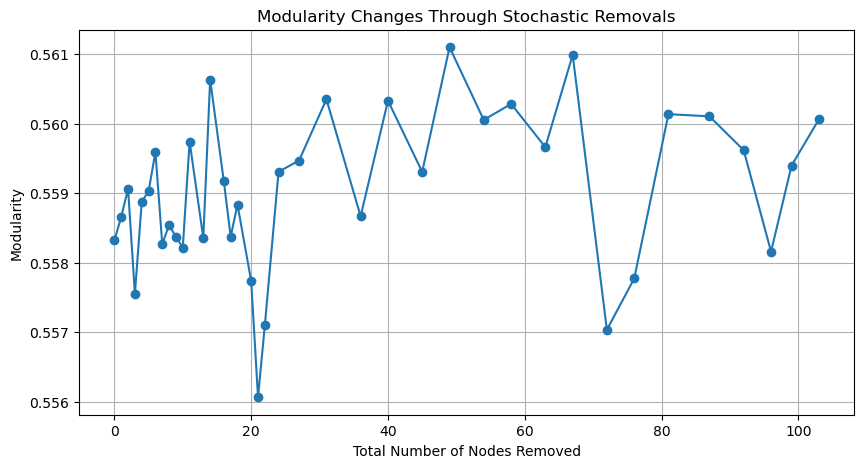

Final modularity after all removals: 0.5600620250100178


In [73]:
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
import random
import numpy as np
from tqdm.notebook import tqdm

def stochastic_gradient_node_removal(G, types, initial_modularity, max_iterations=100, initial_batch_size=1, gradient_memory=10):
    all_centrality = nx.degree_centrality(G)
    nodes_to_remove = [(node, all_centrality[node]) for node in tqdm(G.nodes()) if node.split('_')[0] in types]
    random.shuffle(nodes_to_remove)  # Randomize node order

    modularities = [initial_modularity]
    removed_nodes_count = [0]
    gradients = []  # To store gradients
    batch_size = initial_batch_size
    total_removed = 0

    # Initial sampling to set dynamic threshold
    initial_samples = min(10, len(nodes_to_remove))  # At least 10 samples or fewer if not available
    for _ in range(initial_samples):
        node, _ = nodes_to_remove.pop(0)
        G.remove_node(node)
        total_removed += 1
        new_partition = community_louvain.best_partition(G, random_state=42)
        new_modularity = community_louvain.modularity(new_partition, G)
        modularities.append(new_modularity)
        removed_nodes_count.append(total_removed)
        gradients.append(new_modularity - modularities[-2])

    # Calculate dynamic threshold based on initial samples
    mean_initial_gradient = np.mean(gradients)
    std_initial_gradient = np.std(gradients)
    stop_threshold = mean_initial_gradient - std_initial_gradient  # Example formula
    print(f"Stop Threshold: {stop_threshold}")

    # Main removal loop
    progress_bar = tqdm(total=max_iterations, desc="Processing")
    while nodes_to_remove and total_removed < max_iterations:
        current_batch = nodes_to_remove[:batch_size]
        nodes_to_remove = nodes_to_remove[batch_size:]

        for node, _ in current_batch:
            G.remove_node(node)
            total_removed += 1

        new_partition = community_louvain.best_partition(G, random_state=42)
        new_modularity = community_louvain.modularity(new_partition, G)
        modularities.append(new_modularity)
        removed_nodes_count.append(total_removed)

        # Calculate and store the gradient
        current_gradient = new_modularity - modularities[-2]
        gradients.append(current_gradient)

        # Maintain only the last 'gradient_memory' gradients
        if len(gradients) > gradient_memory:
            gradients.pop(0)

        # Check stop condition
        if len(gradients) == gradient_memory and np.mean(gradients) < stop_threshold:
            print(f"Stopping: Average gradient over last {gradient_memory} iterations below {stop_threshold}.")
            break

        # Adjust batch size based on change in modularity (gradient)
        if current_gradient > 0:
            batch_size = min(len(nodes_to_remove), batch_size + 1)  # Increase batch size if the gradient is positive
        else:
            batch_size = max(1, batch_size - 1)  # Decrease batch size if negative

        print(f"Iteration {total_removed}: Removed {len(current_batch)} nodes, New Modularity = {new_modularity}")
        progress_bar.update(len(current_batch))

    plt.figure(figsize=(10, 5))
    plt.plot(removed_nodes_count, modularities, marker='o')
    plt.xlabel('Total Number of Nodes Removed')
    plt.ylabel('Modularity')
    plt.title('Modularity Changes Through Stochastic Removals')
    plt.grid(True)
    plt.show()

    return modularities[-1]

# Assuming 'G' is your graph and 'analyzer' and 'kg' are defined to help build it
# G = analyzer.build_graph(kg.G)
types_to_analyze = ['brand', 'category', 'related_product', 'word']
initial_partition = community_louvain.best_partition(G, random_state=42)
initial_modularity = community_louvain.modularity(initial_partition, G)
final_modularity = stochastic_gradient_node_removal(G, types_to_analyze, initial_modularity)
print(f"Final modularity after all removals: {final_modularity}")


In [ ]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from community import community_louvain
# from tqdm.notebook import tqdm

# def remove_nodes_and_plot_modularity(G, types):
#     print('hola')
#     all_centrality = nx.degree_centrality(G)
#     # Gather all nodes of the specified types
#     # nodes_to_remove = [(node, nx.degree_centrality(G)[node]) for node in G if any(node.startswith(t) for t in types)]
#     # nodes_to_remove = [(node, nx.degree_centrality(G)[node]) for node in tqdm(G) if any(node.startswith(t) for t in types)]
#     nodes_to_remove = [(node, all_centrality[node]) for node in tqdm(G.nodes()) if node.split('_')[0] in types]
#     # Sort nodes by degree centrality, highest first
#     nodes_to_remove.sort(key=lambda x: x[1], reverse=True)

#     # Initialize data for plotting
#     modularities = []
#     removed_nodes_count = []

#     # Compute initial modularity
#     print(1)
#     partition = community_louvain.best_partition(G, random_state=42)
#     print(2)
#     initial_modularity = community_louvain.modularity(partition, G)
#     print(3)
#     modularities.append(initial_modularity)
#     removed_nodes_count.append(0)

#     # Remove nodes one by one and recalculate modularity
#     for i, (node, _) in tqdm(enumerate(nodes_to_remove, 1), desc='proc'):
#         print(4)
#         G.remove_node(node)
#         new_partition = community_louvain.best_partition(G, random_state=42)
#         new_modularity = community_louvain.modularity(new_partition, G)
#         modularities.append(new_modularity)
#         removed_nodes_count.append(i)
#         print(f"Removed {node}: new modularity = {new_modularity}")

#     # Plotting the modularity changes
#     plt.figure(figsize=(10, 5))
#     plt.plot(removed_nodes_count, modularities, marker='o')
#     plt.xlabel('Number of Nodes Removed')
#     plt.ylabel('Modularity')
#     plt.title('Changes in Modularity After Node Removal')
#     plt.grid(True)
#     plt.show()

#     return modularities[-1]

# # Assuming 'G' is your graph and 'analyzer' and 'kg' are defined to help build it

# # Types of nodes to focus on
# types_to_analyze = ['brand', 'category', 'related_product', 'word']
# final_modularity = remove_nodes_and_plot_modularity(G, types_to_analyze)
# print(f"Final modularity after all removals: {final_modularity}")

## High degree centrality nodes removal

In [85]:
degree_centrality = nx.degree_centrality(G)

In [82]:
degree_centrality

{'product_0': 0.0011386528860471228,
 'category_17': 0.0008174943797261394,
 'category_18': 0.00017517736708417273,
 'category_19': 8.758868354208637e-05,
 'brand_1': 0.00011678491138944849,
 'word_849': 0.00020437359493153485,
 'word_1627': 0.00023356982277889697,
 'word_1715': 0.00035035473416834546,
 'word_2161': 8.758868354208637e-05,
 'word_2637': 0.00023356982277889697,
 'word_2930': 2.9196227847362122e-05,
 'word_3316': 0.00017517736708417273,
 'word_3614': 2.9196227847362122e-05,
 'word_4268': 0.00035035473416834546,
 'word_4837': 0.0002627660506262591,
 'word_4866': 0.0005255321012525182,
 'word_5320': 0.0002627660506262591,
 'word_5653': 8.758868354208637e-05,
 'word_8524': 5.8392455694724244e-05,
 'word_9059': 0.00035035473416834546,
 'word_10123': 0.00046713964555779395,
 'word_10224': 5.8392455694724244e-05,
 'word_10337': 0.0007882981518787773,
 'related_product_401': 2.9196227847362122e-05,
 'related_product_3452': 5.8392455694724244e-05,
 'related_product_3531': 2.91962

In [60]:
node_types = set()
for node, degree in degree_centrality.items():
    node_type, node_id = node.rsplit('_', 1)
    node_types.add(node_type)
node_types


{'brand', 'category', 'product', 'related_product', 'word'}

In [88]:
node_type_centralities['brand']

[('brand_2', 0.00035035473416834546),
 ('brand_18', 0.00032115850632098334),
 ('brand_19', 0.0002919622784736212),
 ('brand_17', 0.0002627660506262591),
 ('brand_12', 0.00023356982277889697),
 ('brand_45', 0.00017517736708417273),
 ('brand_133', 0.0001459811392368106),
 ('brand_55', 0.0001459811392368106),
 ('brand_58', 0.0001459811392368106),
 ('brand_109', 0.0001459811392368106),
 ('brand_43', 0.0001459811392368106),
 ('brand_1', 0.00011678491138944849),
 ('brand_46', 0.00011678491138944849),
 ('brand_68', 0.00011678491138944849),
 ('brand_28', 0.00011678491138944849),
 ('brand_4', 0.00011678491138944849),
 ('brand_262', 0.00011678491138944849),
 ('brand_177', 8.758868354208637e-05),
 ('brand_89', 8.758868354208637e-05),
 ('brand_227', 8.758868354208637e-05),
 ('brand_27', 8.758868354208637e-05),
 ('brand_285', 8.758868354208637e-05),
 ('brand_80', 8.758868354208637e-05),
 ('brand_312', 8.758868354208637e-05),
 ('brand_175', 8.758868354208637e-05),
 ('brand_7', 8.758868354208637e-05)

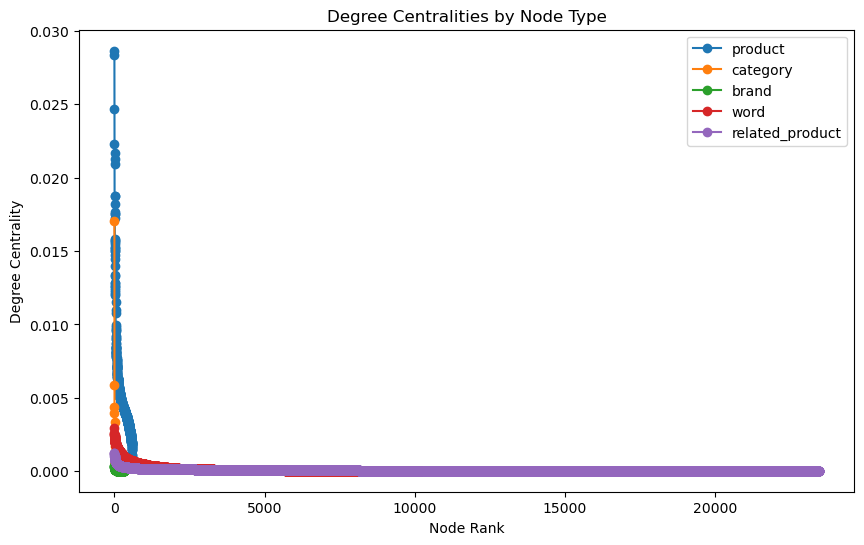

In [76]:
node_types = set()
node_type_centralities = {}

for node, centrality in degree_centrality.items():
    node_type, node_id = node.rsplit('_', 1)
    node_types.add(node_type)
    if node_type not in node_type_centralities:
        node_type_centralities[node_type] = []
    node_type_centralities[node_type].append((node, centrality))

# Sort the degree centralities for each node type
for node_type in node_type_centralities:
    node_type_centralities[node_type].sort(key=lambda x: x[1], reverse=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for node_type, centralities in node_type_centralities.items():
    nodes, centrality_values = zip(*centralities)
    ax.plot(range(len(centrality_values)), centrality_values, label=node_type, marker='o')

ax.set_xlabel('Node Rank')
ax.set_ylabel('Degree Centrality')
ax.set_title('Degree Centralities by Node Type')
ax.legend()
plt.show()

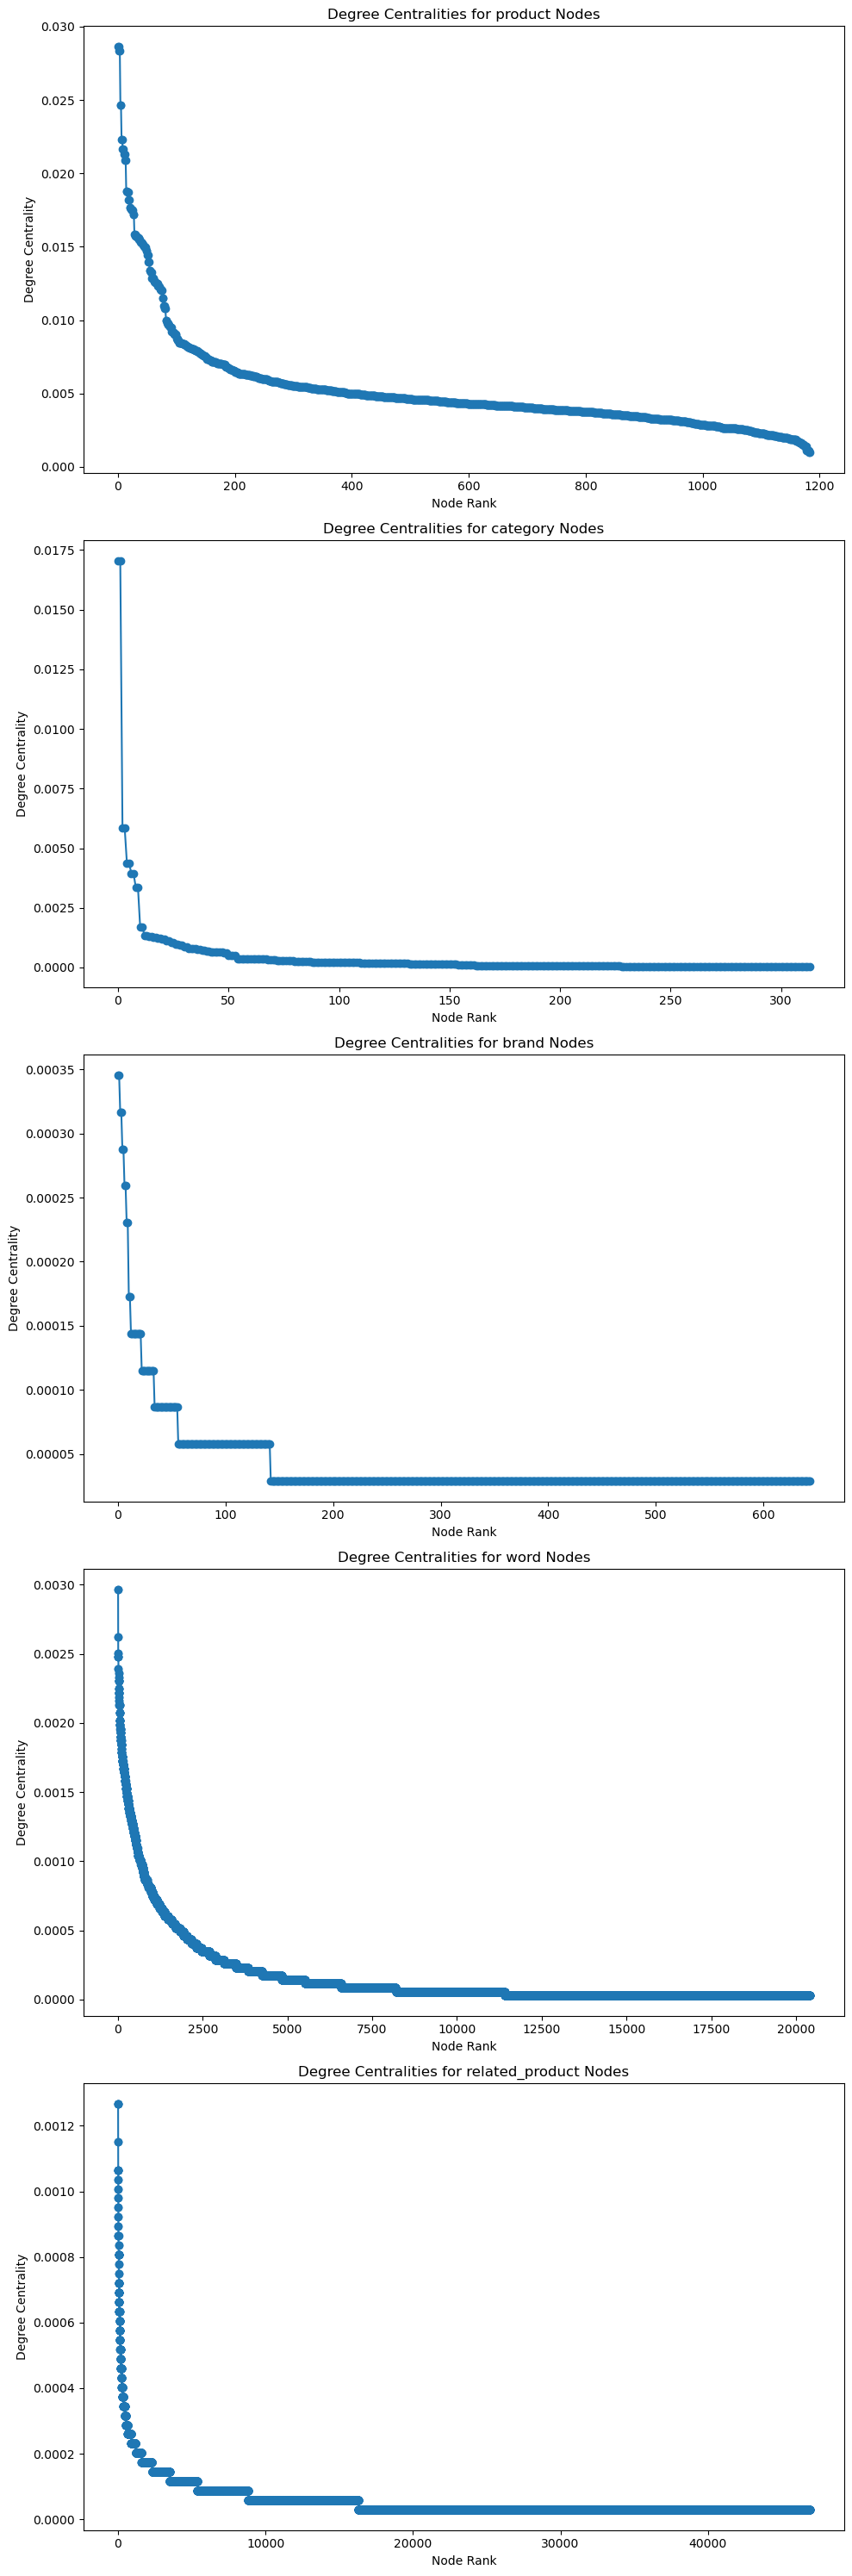

In [77]:
for node, centrality in degree_centrality.items():
    node_type, node_id = node.rsplit('_', 1)
    node_types.add(node_type)
    if node_type not in node_type_centralities:
        node_type_centralities[node_type] = []
    node_type_centralities[node_type].append((node, centrality))

# Sort the degree centralities for each node type
for node_type in node_type_centralities:
    node_type_centralities[node_type].sort(key=lambda x: x[1], reverse=True)

# Determine the number of subplots needed
num_types = len(node_types)
fig, axs = plt.subplots(num_types, 1, figsize=(10, 6 * num_types))

if num_types == 1:
    axs = [axs]

# Plotting each node type in a separate subplot
for ax, node_type in zip(axs, node_type_centralities):
    centralities = node_type_centralities[node_type]
    nodes, centrality_values = zip(*centralities)
    ax.plot(range(len(centrality_values)), centrality_values, marker='o')
    ax.set_xlabel('Node Rank')
    ax.set_ylabel('Degree Centrality')
    ax.set_title(f'Degree Centralities for {node_type} Nodes')

plt.tight_layout()
plt.show()

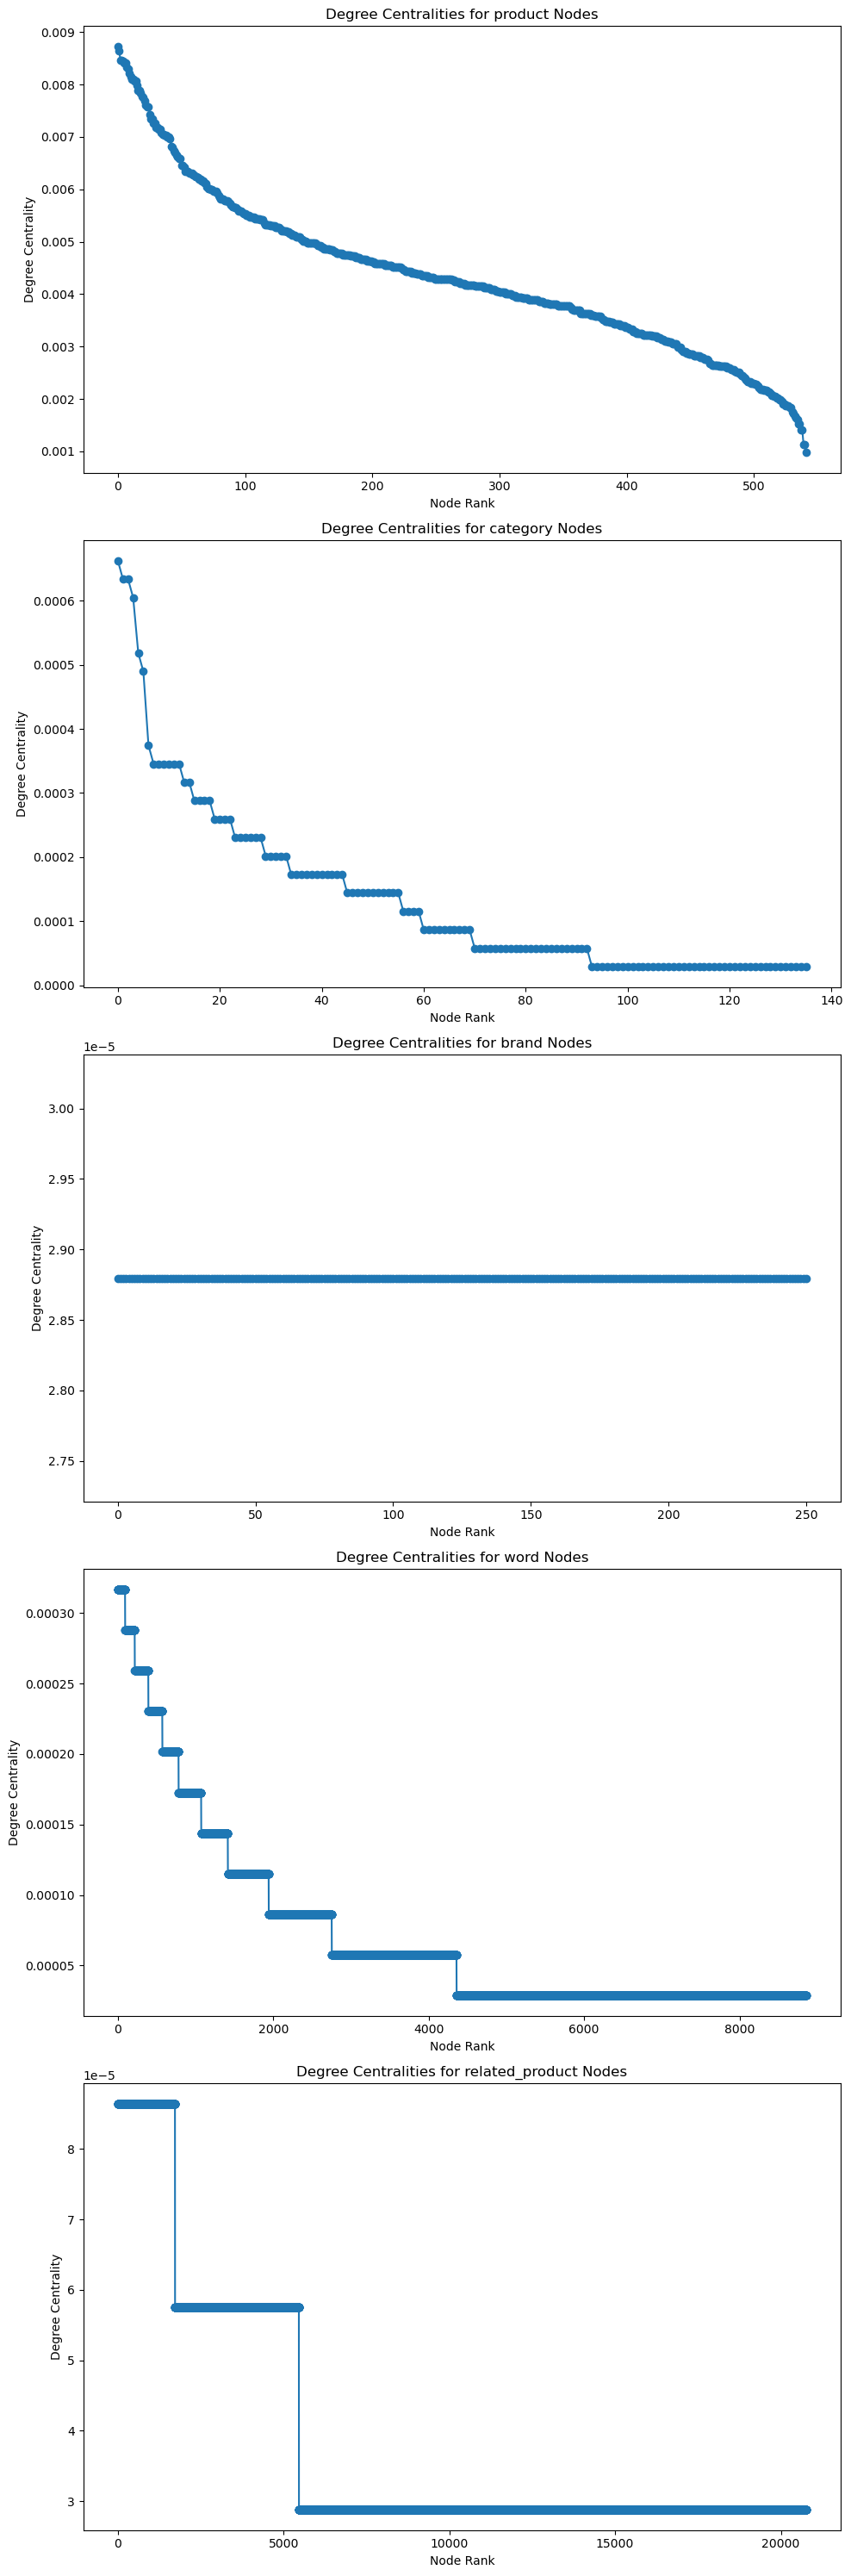

In [78]:
import matplotlib.pyplot as plt
import numpy as np



# Extract node types and organize degree centralities by type
node_types = set()
node_type_centralities = {}

for node, centrality in degree_centrality.items():
    node_type, node_id = node.rsplit('_', 1)
    node_types.add(node_type)
    if node_type not in node_type_centralities:
        node_type_centralities[node_type] = []
    node_type_centralities[node_type].append((node, centrality))

# Sort the degree centralities for each node type
for node_type in node_type_centralities:
    node_type_centralities[node_type].sort(key=lambda x: x[1], reverse=True)

# Function to remove outliers using the IQR method
def remove_outliers(data):
    centrality_values = np.array([x[1] for x in data])
    Q1 = np.percentile(centrality_values, 25)
    Q3 = np.percentile(centrality_values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = [x for x in data if lower_bound <= x[1] <= upper_bound]
    return filtered_data

# Remove outliers for each node type
for node_type in node_type_centralities:
    node_type_centralities[node_type] = remove_outliers(node_type_centralities[node_type])

# Determine the number of subplots needed
num_types = len(node_types)
fig, axs = plt.subplots(num_types, 1, figsize=(10, 6 * num_types))

if num_types == 1:
    axs = [axs]

# Plotting each node type in a separate subplot
for ax, node_type in zip(axs, node_type_centralities):
    centralities = node_type_centralities[node_type]
    if centralities:
        nodes, centrality_values = zip(*centralities)
        ax.plot(range(len(centrality_values)), centrality_values, marker='o')
    ax.set_xlabel('Node Rank')
    ax.set_ylabel('Degree Centrality')
    ax.set_title(f'Degree Centralities for {node_type} Nodes')

plt.tight_layout()
plt.show()


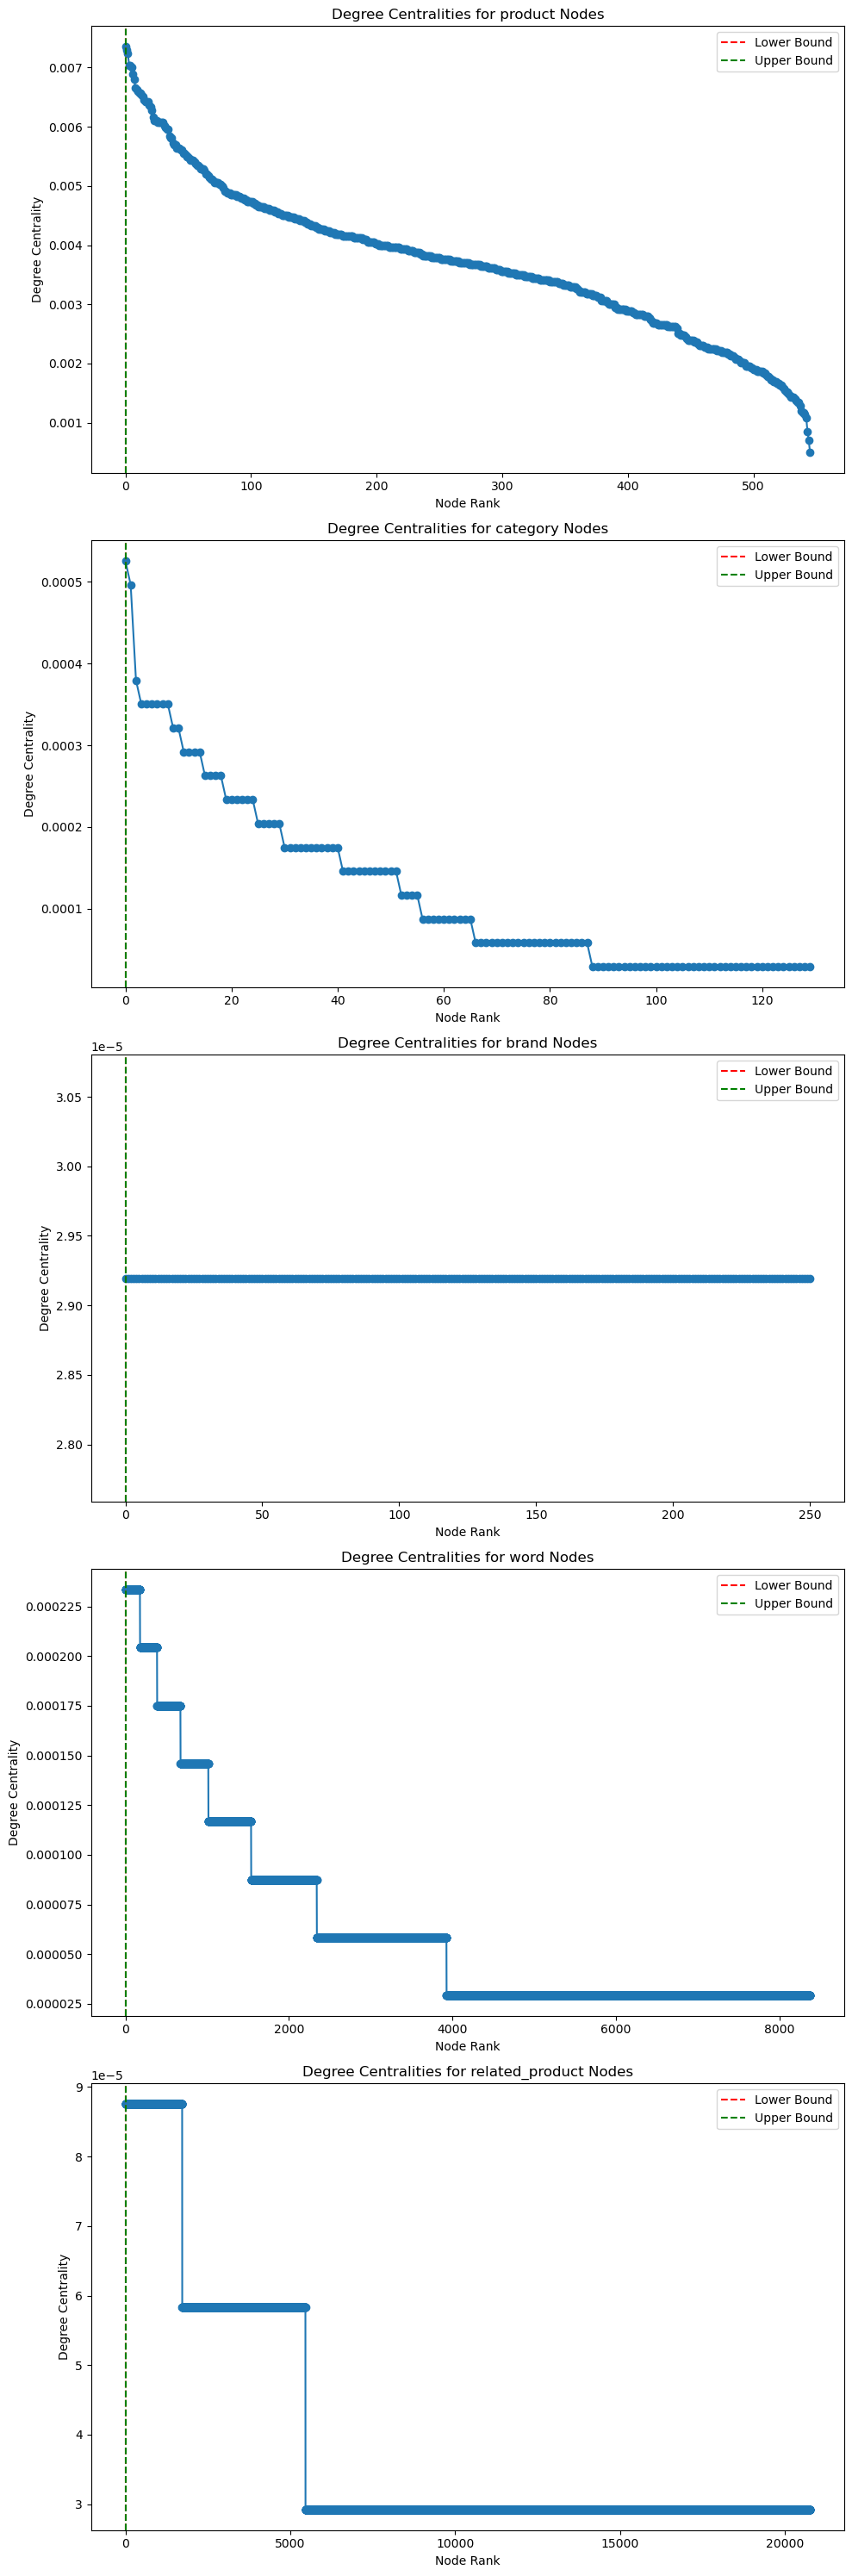

In [83]:
import matplotlib.pyplot as plt
import numpy as np


# Extract node types and organize degree centralities by type
node_types = set()
node_type_centralities = {}

for node, centrality in degree_centrality.items():
    node_type, node_id = node.rsplit('_', 1)
    node_types.add(node_type)
    if node_type not in node_type_centralities:
        node_type_centralities[node_type] = []
    node_type_centralities[node_type].append((node, centrality))

# Sort the degree centralities for each node type
for node_type in node_type_centralities:
    node_type_centralities[node_type].sort(key=lambda x: x[1], reverse=True)

# Function to remove outliers and return bounds
def remove_outliers(data):
    centrality_values = np.array([x[1] for x in data])
    Q1 = np.percentile(centrality_values, 25)
    Q3 = np.percentile(centrality_values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = [x for x in data if lower_bound <= x[1] <= upper_bound]
    return filtered_data, lower_bound, upper_bound

# Remove outliers for each node type and store bounds
bounds = {}
for node_type in node_type_centralities:
    filtered_data, lower_bound, upper_bound = remove_outliers(node_type_centralities[node_type])
    node_type_centralities[node_type] = filtered_data
    bounds[node_type] = (lower_bound, upper_bound)

# Determine the number of subplots needed
num_types = len(node_types)
fig, axs = plt.subplots(num_types, 1, figsize=(10, 6 * num_types), squeeze=False)
axs = axs.flatten()

# Plotting each node type in a separate subplot
for ax, node_type in zip(axs, node_type_centralities):
    centralities = node_type_centralities[node_type]
    if centralities:
        nodes, centrality_values = zip(*centralities)
        ax.plot(range(len(centrality_values)), centrality_values, marker='o')
        lower_bound, upper_bound = bounds[node_type]
        # Plot vertical lines for lower and upper bounds
        ax.axvline(x=lower_bound, color='r', linestyle='--', label='Lower Bound')
        ax.axvline(x=upper_bound, color='g', linestyle='--', label='Upper Bound')
    ax.set_xlabel('Node Rank')
    ax.set_ylabel('Degree Centrality')
    ax.set_title(f'Degree Centralities for {node_type} Nodes')
    ax.legend()

plt.tight_layout()
plt.show()


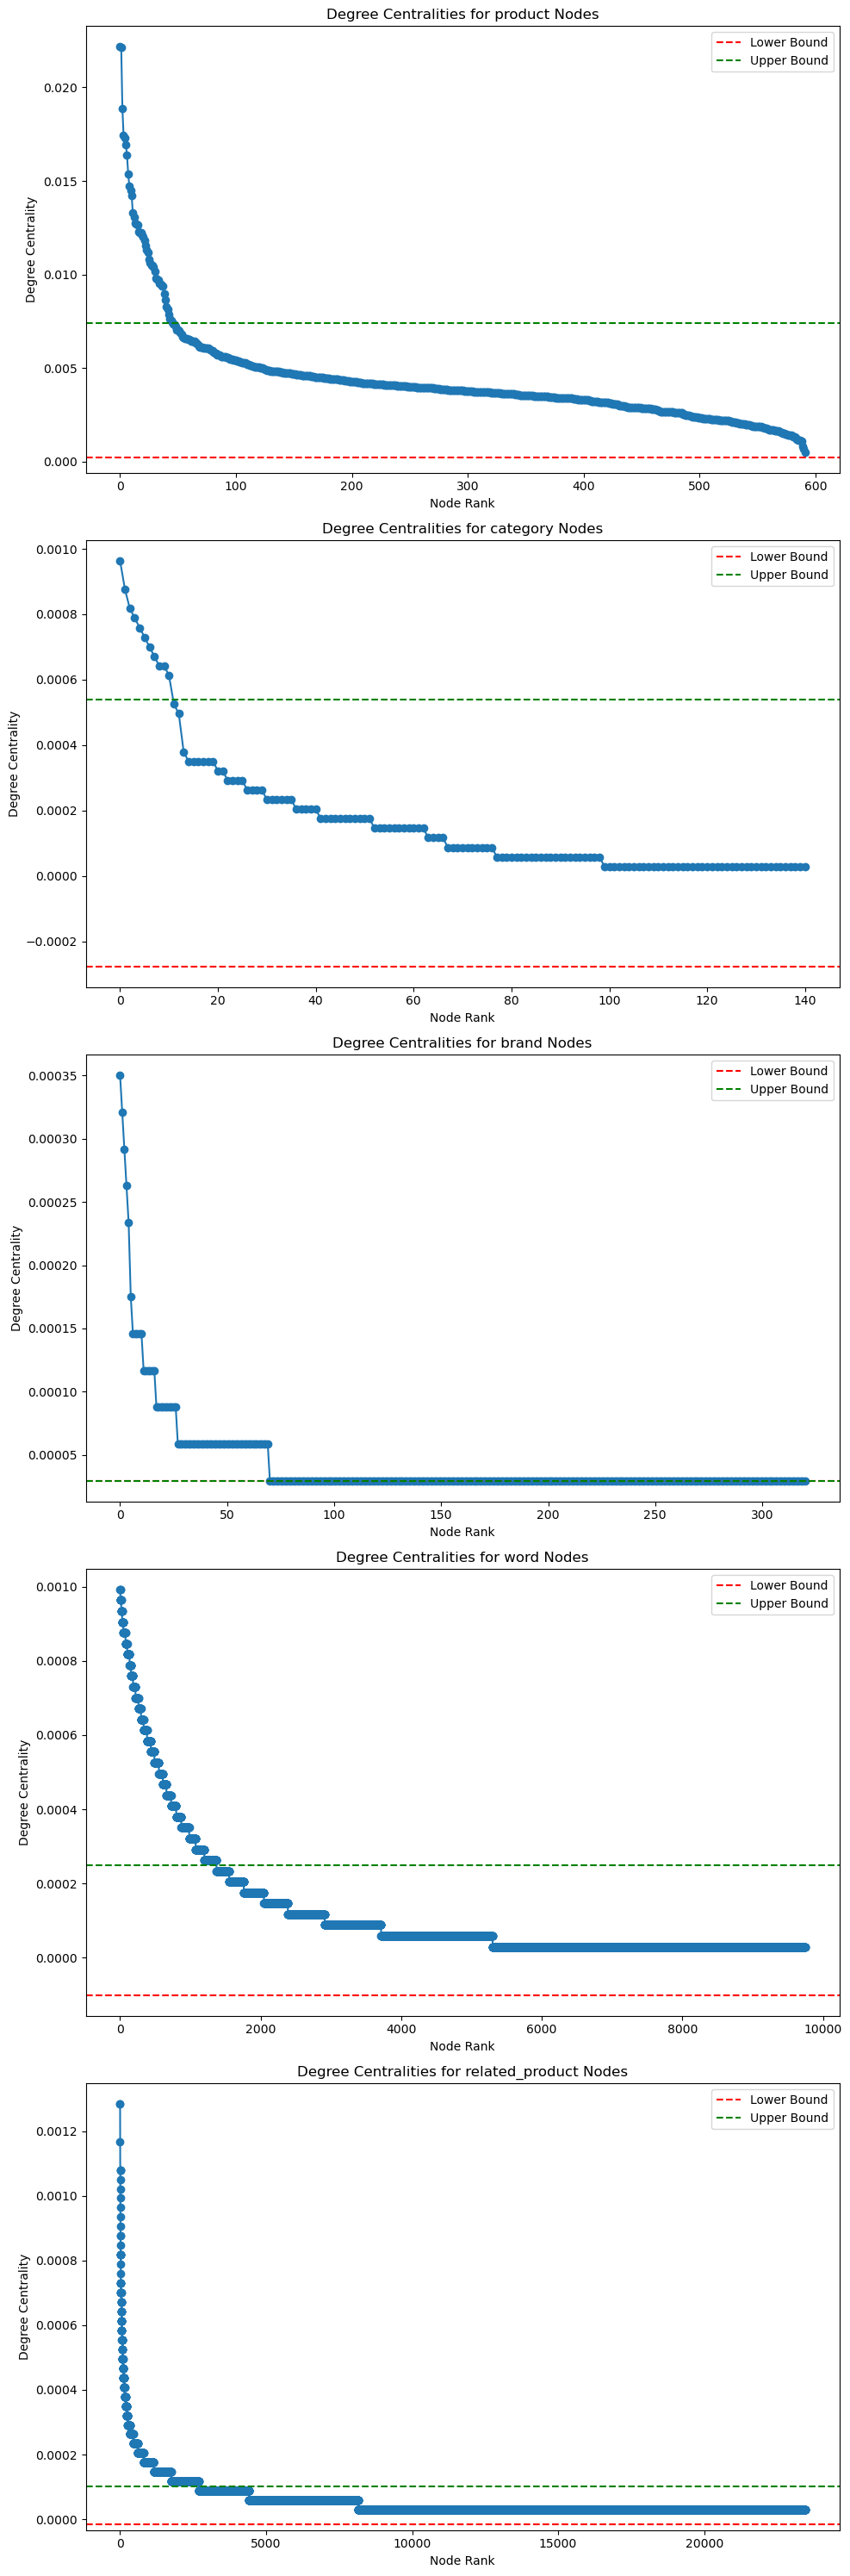

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data structure for degree_centrality

# Extract node types and organize degree centralities by type
node_types = set()
node_type_centralities = {}

for node, centrality in degree_centrality.items():
    node_type, node_id = node.rsplit('_', 1)
    node_types.add(node_type)
    if node_type not in node_type_centralities:
        node_type_centralities[node_type] = []
    node_type_centralities[node_type].append((node, centrality))

# Sort the degree centralities for each node type
for node_type in node_type_centralities:
    node_type_centralities[node_type].sort(key=lambda x: x[1], reverse=True)

# Function to calculate outlier bounds
def calculate_bounds(data):
    centrality_values = np.array([x[1] for x in data])
    Q1 = np.percentile(centrality_values, 25)
    Q3 = np.percentile(centrality_values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Determine the number of subplots needed
num_types = len(node_types)
fig, axs = plt.subplots(num_types, 1, figsize=(10, 6 * num_types), squeeze=False)
axs = axs.flatten()

# Plotting each node type in a separate subplot
for ax, node_type in zip(axs, node_type_centralities):
    centralities = node_type_centralities[node_type]
    if centralities:
        nodes, centrality_values = zip(*centralities)
        ax.plot(range(len(centrality_values)), centrality_values, marker='o')
        # Calculate and plot bounds
        lower_bound, upper_bound = calculate_bounds(centralities)
        ax.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
        ax.axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')
    ax.set_xlabel('Node Rank')
    ax.set_ylabel('Degree Centrality')
    ax.set_title(f'Degree Centralities for {node_type} Nodes')
    ax.legend()

plt.tight_layout()
plt.show()


In [61]:
# Dictionary to hold lists for each type
types = {}

# Separate nodes based on their type
for node, degree in degree_centrality.items():
    node_type, node_id = node.rsplit('_', 1)
    if node_type not in types:
        types[node_type] = []
    types[node_type].append((node, degree))

# Sort each list in the dictionary by degree centrality
for node_type in types:
    types[node_type].sort(key=lambda x: x[1], reverse=True)

# Print sorted lists
for node_type, nodes in types.items():
    print(f"{node_type}:")
    for node, degree in nodes:
        print(f"  {node}: {degree}")

product:
  product_185: 0.02865288256637678
  product_410: 0.028364913897367967
  product_54: 0.024650118067154295
  product_521: 0.022317571848182918
  product_220: 0.021655243909462652
  product_529: 0.021280884639751196
  product_325: 0.02090652537003974
  product_502: 0.018775557219374534
  product_464: 0.01871796348557277
  product_16: 0.018199619881356908
  product_125: 0.017652479410240167
  product_215: 0.017537291942636642
  product_36: 0.01750849507573576
  product_33: 0.01722052640672695
  product_339: 0.015838276795484652
  product_498: 0.01575188619478201
  product_153: 0.015665495594079364
  product_552: 0.015607901860277603
  product_541: 0.015463917525773196
  product_322: 0.01529113632436791
  product_280: 0.015233542590566147
  product_358: 0.015147151989863503
  product_455: 0.015003167655359098
  product_262: 0.014974370788458216
  product_188: 0.014743995853251167
  product_368: 0.014427230317341474
  product_442: 0.013966480446927375
  product_564: 0.0133617462420

---

In [27]:
import networkx as nx
from community import community_louvain
import numpy as np

def analyze_community_sizes(graph, partition):
    sizes = [len(community) for community in partition]
    mean_size = np.mean(sizes)
    std_dev = np.std(sizes)
    large_threshold = mean_size + 2 * std_dev
    
    # Identify large communities
    large_communities = [community for community in partition if len(community) > large_threshold]
    
    return large_communities

def subdivide_large_communities(graph, large_communities):
    subdivided_communities = []
    community_id = 0  # to ensure unique community ids across all subdivisions
    for community in large_communities:
        subgraph = graph.subgraph(community)
        sub_partition = community_louvain.best_partition(subgraph, resolution=1.0)
        # Adjust community identifiers to be unique across the whole graph
        adjusted_partition = {node: sub_com + community_id for node, sub_com in sub_partition.items()}
        community_id += len(set(sub_partition.values()))  # increment to avoid overlapping community ids
        subdivided_communities.append(adjusted_partition)
    return subdivided_communities

def flatten_partitions(partitions):
    # Flattens a list of dictionaries into a single dictionary
    flattened = {}
    for partition in partitions:
        flattened.update(partition)
    return flattened

def calculate_modularity(graph, partition):
    return community_louvain.modularity(partition, graph)

# Example usage
# G = nx.karate_club_graph()  # Example graph
partition2 = community_louvain.best_partition(G)
initial_modularity = calculate_modularity(G, partition2)

In [31]:
partition2

{'product_0': 16,
 'category_0': 6,
 'category_4': 16,
 'category_17': 3,
 'category_18': 16,
 'category_19': 16,
 'brand_1': 16,
 'word_849': 0,
 'word_1065': 5,
 'word_1418': 16,
 'word_1627': 5,
 'word_1715': 16,
 'word_2079': 6,
 'word_2161': 16,
 'word_2637': 16,
 'word_2930': 16,
 'word_2940': 16,
 'word_3316': 16,
 'word_3614': 16,
 'word_4268': 8,
 'word_4421': 6,
 'word_4837': 16,
 'word_4852': 8,
 'word_4866': 6,
 'word_5320': 16,
 'word_5653': 16,
 'word_8247': 16,
 'word_8524': 16,
 'word_9059': 5,
 'word_10123': 16,
 'word_10224': 16,
 'word_10336': 16,
 'word_10337': 16,
 'related_product_401': 16,
 'related_product_3452': 16,
 'related_product_3531': 16,
 'related_product_3533': 16,
 'related_product_3535': 2,
 'related_product_3538': 16,
 'related_product_4014': 16,
 'related_product_4015': 16,
 'related_product_4016': 16,
 'related_product_4017': 16,
 'related_product_4019': 16,
 'related_product_4102': 16,
 'related_product_4103': 16,
 'related_product_4104': 16,
 're

---

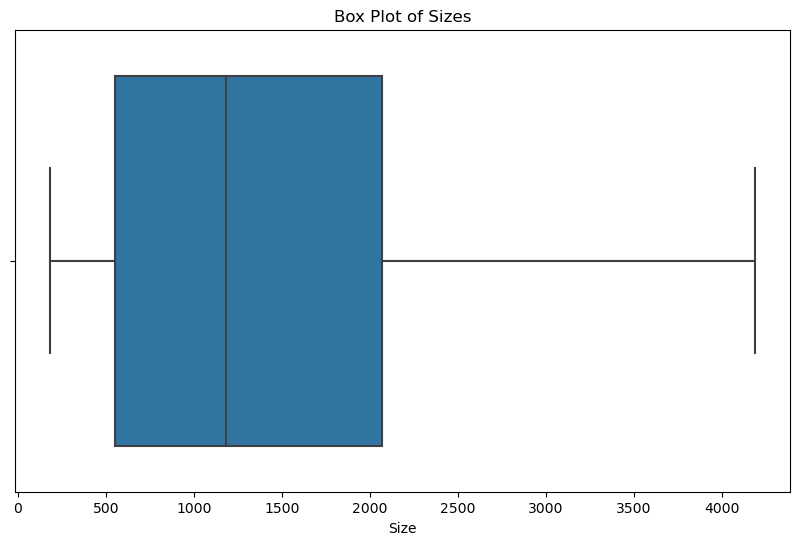

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
sizes = [2660, 173, 2926, 1486, 4010, 1478, 4313, 1688, 2009, 2329, 589, 924, 407, 920, 625, 1696, 320, 1580, 1822, 999, 273, 288, 182, 263, 290, 181, 296]
sizes = list(community_sizes.values())
# Plotting the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=sizes)
plt.title('Box Plot of Sizes')
plt.xlabel('Size')
plt.show()


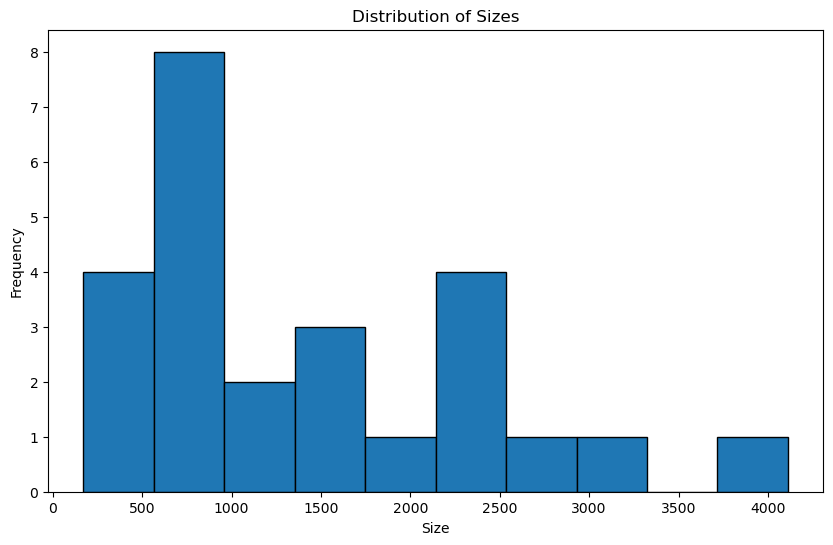

In [44]:
import matplotlib.pyplot as plt

# Data
# sizes = [2660, 173, 2926, 1486, 4010, 1478, 4313, 1688, 2009, 2329, 589, 924, 407, 920, 625, 1696, 320, 1580, 1822, 999, 273, 288, 182, 263, 290, 181, 296]
sizes = list(community_sizes.values())
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(sizes, bins=10, edgecolor='black')
plt.title('Distribution of Sizes')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show()


In [12]:
composition_report = analyzer.report_community_composition()
composition_report

{'Community 0': {'product': 35,
  'category': 12,
  'brand': 22,
  'word': 921,
  'related_product': 1078},
 'Community 1': {'category': 11,
  'word': 324,
  'related_product': 903,
  'product': 20,
  'brand': 12},
 'Community 2': {'category': 6,
  'word': 669,
  'related_product': 1445,
  'product': 36,
  'brand': 15},
 'Community 3': {'word': 826,
  'related_product': 2045,
  'category': 14,
  'product': 59,
  'brand': 27},
 'Community 4': {'word': 1201,
  'related_product': 2842,
  'product': 85,
  'category': 25,
  'brand': 32},
 'Community 5': {'word': 388,
  'category': 9,
  'related_product': 660,
  'brand': 9,
  'product': 18},
 'Community 6': {'product': 27,
  'category': 7,
  'word': 459,
  'related_product': 1353,
  'brand': 14},
 'Community 7': {'category': 10,
  'word': 792,
  'related_product': 1744,
  'product': 40,
  'brand': 24},
 'Community 8': {'category': 1,
  'word': 115,
  'related_product': 169,
  'product': 5,
  'brand': 1},
 'Community 9': {'word': 1016,
  'pro

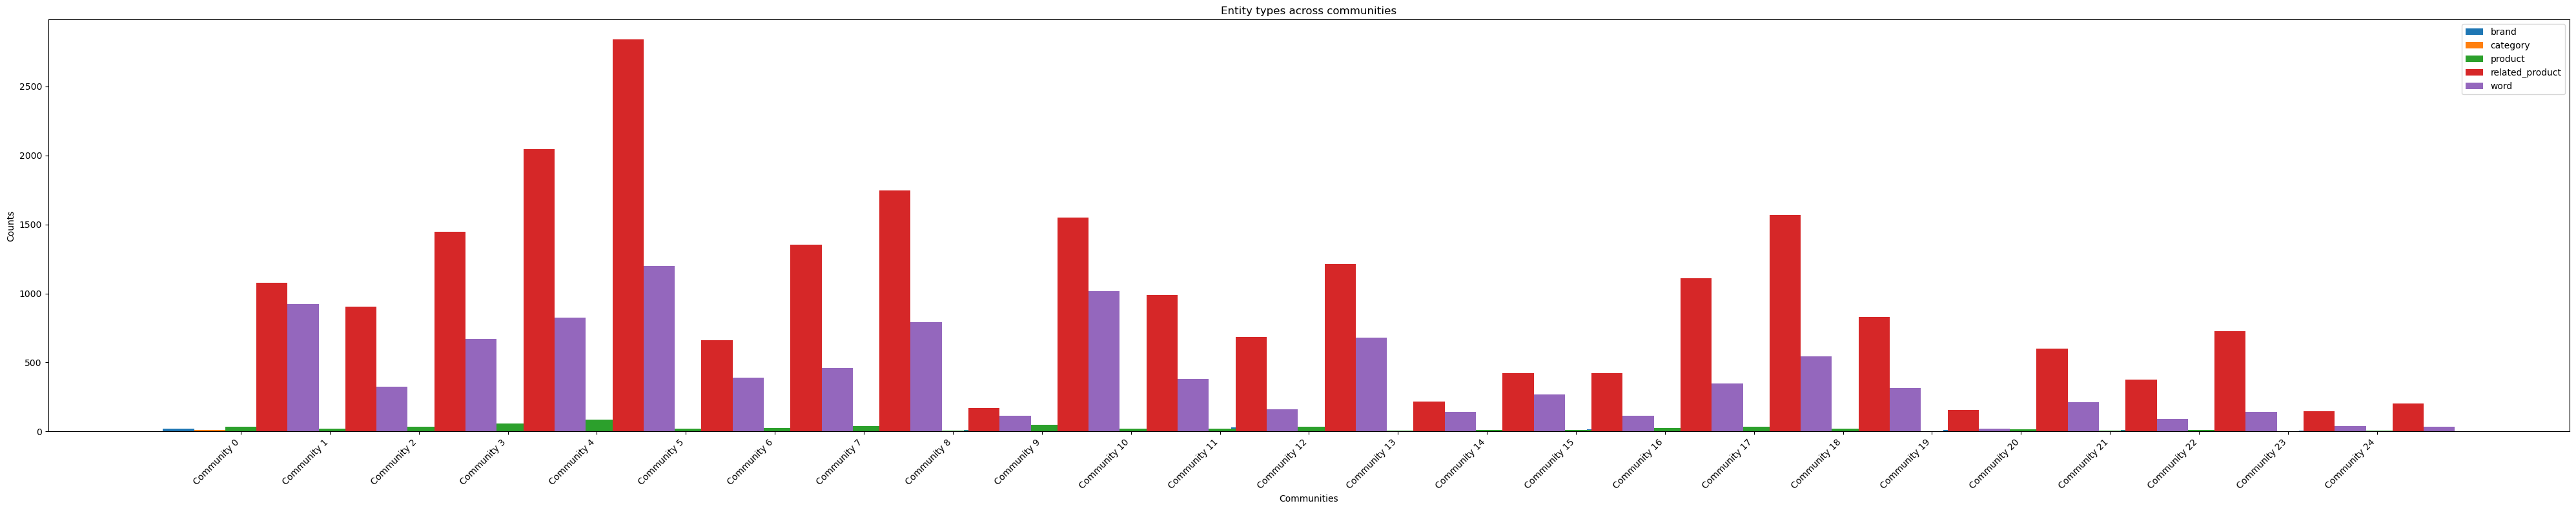

In [13]:
import matplotlib.pyplot as plt

def plot_community_composition(composition_report):
    # Extracting unique types and ensuring consistent order
    all_types = set(type for comp in composition_report.values() for type in comp)
    all_types = sorted(all_types)  # Sort to maintain order

    communities = list(composition_report.keys())
    bar_width = 0.35  # Bar width

    # Creating a figure and a set of subplots with a larger size
    fig, ax = plt.subplots(figsize=(40, 8))

    for index, entity_type in enumerate(all_types):
        # Extract counts for each community for this type
        counts = [composition_report[community].get(entity_type, 0) for community in communities]
        # Creating offset for each type to avoid overlap
        offsets = [x + index * bar_width for x in range(len(communities))]
        ax.bar(offsets, counts, bar_width, label=entity_type)

    ax.set_xlabel('Communities')
    ax.set_ylabel('Counts')
    ax.set_title('Entity types across communities')
    ax.set_xticks([r + (len(all_types) - 1) * bar_width / 2 for r in range(len(communities))])
    ax.set_xticklabels(communities, rotation=45, ha='right')  # Rotating labels

    ax.legend()

    plt.tight_layout()  # Adjust layout to make room for rotated labels
    plt.show()

# Assuming 'composition_report' is already generated from your analysis
plot_community_composition(composition_report)


In [14]:
def report_community_composition(partition):
    # This method assumes that 'identify_communities' has been called first
    if partition is None:
        raise ValueError("Communities not identified. Please run identify_communities() first.")

    # Initialize a dictionary to store the counts
    community_composition = collections.defaultdict(lambda: collections.Counter())
    
    # Iterate over each node and its community
    for node, community in self.partition.items():
        node_type = G.nodes[node]['type']  # Get the type of the node
        community_composition[community][node_type] += 1  # Increment the count of the type in its community

    # Create a readable report from the composition data
    report = {}
    for community, types in community_composition.items():
        report[f"Community {community}"] = dict(types)

    return report

In [15]:
import collections

In [16]:
report_community_composition(partition)

NameError: name 'self' is not defined

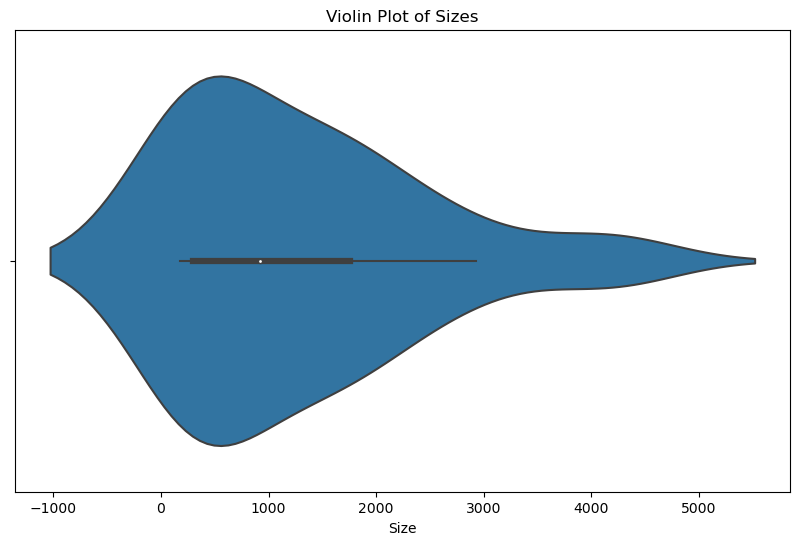

In [17]:
# Plotting the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=sizes)
plt.title('Violin Plot of Sizes')
plt.xlabel('Size')
plt.show()


In [18]:
def attribute_homogeneity(G, partition, attribute):
    attribute_distribution = {}
    for node, community in partition.items():
        node_type = G.nodes[node].get('type', 'unknown')
        if node_type == 'product':
            node_attribute = G.nodes[node].get(attribute, None)
            if community not in attribute_distribution:
                attribute_distribution[community] = []
            attribute_distribution[community].append(node_attribute)
    
    for community, attributes in attribute_distribution.items():
        print(f"Community {community} - {attribute}: {Counter(attributes)}")

# attribute_homogeneity(G, partition, 'brand')


In [19]:
# import matplotlib.pyplot as plt
# import networkx as nx

# def visualize_communities(G, partition):
#     pos = nx.spring_layout(G)
#     cmap = plt.get_cmap('viridis')
#     plt.figure(figsize=(12, 12))
#     nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=50,
#                            cmap=cmap, node_color=list(partition.values()))
#     nx.draw_networkx_edges(G, pos, alpha=0.5)
#     plt.show()

# visualize_communities(G, partition)


In [20]:
attribute_homogeneity(G, partition, 'brand')

KeyError: ('product_0', 'product')

In [ ]:
from collections import Counter

def community_size_distribution(partition):
    size_distribution = Counter(partition.values())
    return size_distribution

size_distribution = community_size_distribution(partition)
print(f"Community Size Distribution: {size_distribution}")


In [ ]:
kg.

---

# modularity check

In [27]:
import networkx as nx
import numpy as np

In [28]:
def evaluate_communities(graph, partition):
    import networkx as nx
    modularity = nx.algorithms.community.modularity(graph, partition)
    sizes = [len(c) for c in partition]
    avg_size = sum(sizes) / len(sizes)
    size_variance = np.var(sizes)

    print(f"Modularity: {modularity}")
    print(f"Average Community Size: {avg_size}")
    print(f"Size Variance: {size_variance}")

    # Additional checks can be added here based on other metrics like homogeneity


In [29]:
# Step 1: Create a dictionary to hold sets of nodes for each community
community_dict = {}

# Step 2: Populate the dictionary with sets of nodes based on community IDs
for (node, _), community_id in partition.items():
    if community_id not in community_dict:
        community_dict[community_id] = set()
    community_dict[community_id].add(node)

# Step 3: Convert the dictionary to a list of sets
community_list = list(community_dict.values())

# Now community_list contains your partitions in the desired format
print("Communities as list of sets:", community_list)

Communities as list of sets: [{'word_5029', 'word_654', 'related_product_7206', 'word_1950', 'product_68', 'word_2656', 'related_product_9249', 'word_4950', 'related_product_4489', 'related_product_2145', 'related_product_12136', 'word_1740', 'word_8471', 'related_product_14684', 'related_product_21496', 'word_3435', 'word_3613', 'word_2600', 'word_375', 'word_2104', 'related_product_9408', 'related_product_21192', 'related_product_9442', 'word_1895', 'related_product_6846', 'related_product_10026', 'related_product_12134', 'word_9059', 'word_1738', 'word_2166', 'brand_85', 'related_product_5827', 'related_product_12176', 'related_product_13897', 'word_6298', 'related_product_9599', 'related_product_10363', 'related_product_4151', 'word_3058', 'word_6410', 'word_2298', 'word_5391', 'category_121', 'word_9902', 'related_product_15224', 'word_4262', 'word_7182', 'word_1772', 'word_735', 'related_product_22595', 'related_product_22124', 'word_8353', 'word_9392', 'word_1124', 'related_prod

In [31]:
len(G)

34727

In [36]:
import numpy as np

def analyze_community_sizes(partition):
    # Calculate the sizes of each community
    sizes = [len(community) for community in partition]
    
    # Compute mean and standard deviation of community sizes
    mean_size = np.mean(sizes)
    std_dev = np.std(sizes)
    
    print(f"Average community size: {mean_size}")
    print(f"Standard deviation of sizes: {std_dev}")
    
    # Define thresholds for large and small communities based on mean and standard deviation
    large_threshold = mean_size + 2 * std_dev
    small_threshold = mean_size - 2 * std_dev
    
    # Identify large and small communities
    large_communities = [community for community in partition if len(community) > large_threshold]
    small_communities = [community for community in partition if len(community) < small_threshold]
    
    # Output the sizes of large and small communities for verification
    print("Large communities (sizes):", [len(community) for community in large_communities])
    print("Small communities (sizes):", [len(community) for community in small_communities])

    return large_communities, small_communities

# Example Usage
# Assuming 'partition' is your list of sets, where each set contains nodes that belong to one community
# partition_example = [{1, 2, 3}, {4, 5, 6, 7, 8, 9, 10}, {11, 12}]  # This is a mock example
large_communities, small_communities = analyze_community_sizes(community_list)

Average community size: 1389.08
Standard deviation of sizes: 999.9084726113686
Large communities (sizes): [4185]
Small communities (sizes): []


[]

In [ ]:
small_communities

In [50]:
import networkx as nx
import numpy as np

def analyze_community_sizes(graph, partition):
    sizes = [len(list(filter(lambda x: x == community, partition.values()))) for community in set(partition.values())]
    mean_size = np.mean(sizes)
    std_dev = np.std(sizes)
    print(f"Average community size: {mean_size}")
    print(f"Standard deviation of sizes: {std_dev}")
    
    # Identify outlier communities
    large_threshold = mean_size + 2 * std_dev
    small_threshold = mean_size - 2 * std_dev
    large_communities = [size for size in sizes if size > large_threshold]
    small_communities = [size for size in sizes if size < small_threshold]
    
    return large_communities, small_communities

# Example usage
# G = nx.karate_club_graph()  # Example graph
# partition = nx.algorithms.community.louvain_communities(G, seed=42)
# large_communities, small_communities = analyze_community_sizes(G, partition)


In [53]:
import networkx as nx
from community import community_louvain
import numpy as np

def analyze_community_sizes(graph, partition):
    sizes = [len(community) for community in partition]
    mean_size = np.mean(sizes)
    std_dev = np.std(sizes)
    large_threshold = mean_size + 2 * std_dev
    
    # Identify large communities
    large_communities = [community for community in partition if len(community) > large_threshold]
    
    return large_communities

def subdivide_large_communities(graph, large_communities):
    subdivided_communities = []
    community_id = 0  # to ensure unique community ids across all subdivisions
    for community in large_communities:
        subgraph = graph.subgraph(community)
        sub_partition = community_louvain.best_partition(subgraph, resolution=1.0)
        # Adjust community identifiers to be unique across the whole graph
        adjusted_partition = {node: sub_com + community_id for node, sub_com in sub_partition.items()}
        community_id += len(set(sub_partition.values()))  # increment to avoid overlapping community ids
        subdivided_communities.append(adjusted_partition)
    return subdivided_communities

def flatten_partitions(partitions):
    # Flattens a list of dictionaries into a single dictionary
    flattened = {}
    for partition in partitions:
        flattened.update(partition)
    return flattened

def calculate_modularity(graph, partition):
    return community_louvain.modularity(partition, graph)

# Example usage
# G = nx.karate_club_graph()  # Example graph
partition = community_louvain.best_partition(G)
initial_modularity = calculate_modularity(G, partition)

# Simulate large communities detection and subdivision
large_communities = [set(G.nodes())]  # Assume all nodes form one large community for the example
subdivisions = subdivide_large_communities(G, large_communities)

# Flatten subdivisions for modularity calculation
flattened_subdivisions = flatten_partitions(subdivisions)
new_modularity = calculate_modularity(G, flattened_subdivisions)

print(f"Initial Modularity: {initial_modularity}")
print(f"New Modularity after subdivision: {new_modularity}")


Initial Modularity: 0.47084659831172143
New Modularity after subdivision: 0.4714984656089286


In [66]:
def analyze_community_sizes(partition):
    sizes = {i: len(community) for i, community in enumerate(partition)}
    mean_size = np.mean(list(sizes.values()))
    std_dev = np.std(list(sizes.values()))
    large_threshold = mean_size + 2 * std_dev
    small_threshold = mean_size - 2 * std_dev
    
    large_communities = [i for i, size in sizes.items() if size > large_threshold]
    small_communities = [i for i, size in sizes.items() if size < small_threshold]
    
    return large_communities, small_communities, sizes

In [ ]:
import networkx as nx
from community import community_louvain
import numpy as np

def analyze_community_sizes(graph, partition):
    sizes = {i: len(community) for i, community in enumerate(partition)}
    mean_size = np.mean(list(sizes.values()))
    std_dev = np.std(list(sizes.values()))
    large_threshold = mean_size + 2 * std_dev
    small_threshold = mean_size - 2 * std_dev
    
    large_communities = [i for i, size in sizes.items() if size > large_threshold]
    small_communities = [i for i, size in sizes.items() if size < small_threshold]
    
    return large_communities, small_communities, sizes

def merge_small_communities(graph, partition, small_communities, sizes, target_size):
    # Attempt to merge small communities based on proximity and combined size
    community_graph = nx.Graph()
    community_graph.add_nodes_from(small_communities)
    
    # Add edges between communities that are geographically close or share nodes
    for i in small_communities:
        for j in small_communities:
            if i != j:
                # Check if communities are close, e.g., share edges or nodes
                shared_nodes = set(partition[i]).intersection(partition[j])
                if shared_nodes:
                    community_graph.add_edge(i, j)
    
    # Use connected components to merge communities
    merged_communities = []
    for component in nx.connected_components(community_graph):
        merged = set()
        for node in component:
            merged.update(partition[node])
        if len(merged) < target_size:
            for node in component:
                # Find the closest community to merge with based on node sharing or edge connections
                neighbors = list(community_graph.neighbors(node))
                if neighbors:
                    closest = max(neighbors, key=lambda x: len(set(partition[node]).intersection(partition[x])))
                    merged.update(partition[closest])
        merged_communities.append(merged)
    
    return merged_communities

def flatten_partitions(partitions):
    flattened = {}
    community_id = 0
    for partition in partitions:
        for node in partition:
            flattened[node] = community_id
        community_id += 1
    return flattened

def calculate_modularity(graph, partition):
    return community_louvain.modularity(partition, graph)

# Example usage
# G = nx.karate_club_graph()
partition = list(community_louvain.best_partition(G).values())
initial_modularity = calculate_modularity(G, partition)

large_communities, small_communities, sizes = analyze_community_sizes(G, partition)
merged_communities = merge_small_communities(G, partition, small_communities, sizes, target_size=10)

# Flatten partitions including merged communities
final_partition = flatten_partitions(merged_communities)
new_modularity = calculate_modularity(G, final_partition)

print(f"Initial Modularity: {initial_modularity}")
print(f"New Modularity after merging small communities: {new_modularity}")


In [54]:
subdivisions

[{'product_0': 0,
  'category_0': 1,
  'category_4': 2,
  'category_17': 3,
  'category_18': 0,
  'category_19': 3,
  'brand_1': 0,
  'word_849': 0,
  'word_1065': 0,
  'word_1418': 0,
  'word_1627': 0,
  'word_1715': 0,
  'word_2079': 4,
  'word_2161': 0,
  'word_2637': 0,
  'word_2930': 0,
  'word_2940': 5,
  'word_3316': 0,
  'word_3614': 0,
  'word_4268': 5,
  'word_4421': 4,
  'word_4837': 0,
  'word_4852': 5,
  'word_4866': 6,
  'word_5320': 0,
  'word_5653': 0,
  'word_8247': 0,
  'word_8524': 0,
  'word_9059': 7,
  'word_10123': 3,
  'word_10224': 0,
  'word_10336': 8,
  'word_10337': 0,
  'related_product_401': 0,
  'related_product_3452': 0,
  'related_product_3531': 0,
  'related_product_3533': 0,
  'related_product_3535': 0,
  'related_product_3538': 0,
  'related_product_4014': 0,
  'related_product_4015': 0,
  'related_product_4016': 0,
  'related_product_4017': 0,
  'related_product_4019': 0,
  'related_product_4102': 0,
  'related_product_4103': 0,
  'related_product_41

In [51]:
analyze_community_sizes(G, partition)

Average community size: 1335.6538461538462
Standard deviation of sizes: 1053.6955093058718


([3974, 3646], [])

In [30]:
evaluate_communities(G, community_list)

Modularity: 0.4720560895429936
Average Community Size: 1389.08
Size Variance: 999816.9536


In [68]:
degree_centrality = nx.degree_centrality(G)

In [91]:
len(node_type_centralities['product'])

592

In [92]:
def product_degree_centrality(G, number_of_products = 592):
    number_of_products = number_of_products
    if len(G) <= 1:
            return {n: 1 for n in G}

    s = 1.0 / number_of_products
    centrality = {n: d * s for n, d in G.degree()}
    return centrality

In [95]:
degree_centrality = product_degree_centrality(G)

In [96]:
node_types = set()
node_type_centralities = {}

for node, centrality in degree_centrality.items():
    node_type, node_id = node.rsplit('_', 1)
    node_types.add(node_type)
    if node_type not in node_type_centralities:
        node_type_centralities[node_type] = []
    node_type_centralities[node_type].append((node, centrality))

In [100]:
sorted(node_type_centralities['category'], key=lambda x: x[1], reverse=True)


[('category_99', 0.05574324324324324),
 ('category_31', 0.05067567567567568),
 ('category_17', 0.0472972972972973),
 ('category_12', 0.045608108108108114),
 ('category_27', 0.04391891891891892),
 ('category_8', 0.04222972972972973),
 ('category_30', 0.04054054054054054),
 ('category_11', 0.03885135135135136),
 ('category_52', 0.037162162162162164),
 ('category_88', 0.037162162162162164),
 ('category_62', 0.03547297297297297),
 ('category_15', 0.030405405405405407),
 ('category_9', 0.028716216216216218),
 ('category_73', 0.02195945945945946),
 ('category_32', 0.02027027027027027),
 ('category_6', 0.02027027027027027),
 ('category_74', 0.02027027027027027),
 ('category_50', 0.02027027027027027),
 ('category_25', 0.02027027027027027),
 ('category_29', 0.02027027027027027),
 ('category_38', 0.018581081081081082),
 ('category_107', 0.018581081081081082),
 ('category_63', 0.016891891891891893),
 ('category_10', 0.016891891891891893),
 ('category_138', 0.016891891891891893),
 ('category_84', 

In [99]:
node_type_centralities['category']

[('category_17', 0.0472972972972973),
 ('category_18', 0.010135135135135136),
 ('category_19', 0.005067567567567568),
 ('category_8', 0.04222972972972973),

[('category_17', 0.0472972972972973),
 ('category_18', 0.010135135135135136),
 ('category_19', 0.005067567567567568),
 ('category_8', 0.04222972972972973),
 ('category_9', 0.028716216216216218),
 ('category_31', 0.05067567567567568),
 ('category_62', 0.03547297297297297),
 ('category_63', 0.016891891891891893),
 ('category_64', 0.010135135135135136),
 ('category_116', 0.0033783783783783786),
 ('category_147', 0.0033783783783783786),
 ('category_125', 0.008445945945945946),
 ('category_30', 0.04054054054054054),
 ('category_60', 0.013513513513513514),
 ('category_56', 0.015202702702702704),
 ('category_32', 0.02027027027027027),
 ('category_87', 0.013513513513513514),
 ('category_10', 0.016891891891891893),
 ('category_11', 0.03885135135135136),
 ('category_6', 0.02027027027027027),
 ('category_21', 0.011824324324324325),
 ('category_52', 0.037162162162162164),
 ('category_53', 0.011824324324324325),
 ('category_54', 0.0033783783783783786),
 ('category_74', 0.02027027027027027),
 ('cate

In [70]:
degree_centrality['category_0']

0.017047745205321662